<h1> Articulated Chain Project </h1>

OPT202 first project. Code written by Andrea Simonetto, dated: 31/01/2023

<strong> Setting up </strong>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def cost(x):
    N = int(len(x)/2)
    e = np.zeros(2*N)
    e[N:2*N] = np.ones(N)
    return np.dot(e, x)

def residual(x, L, a, b):
    N = int(len(x) / 2)
    # r for me is c(z), r for residual
    r = np.zeros(N+1)
    r[0] = (x[0] - 0.) ** 2 + (x[N] - 0.) ** 2 - L ** 2
    for i in range(1,N):
        r[i] = (x[i] - x[i-1])**2 + (x[N+i]-x[N+i - 1])**2 - L**2
    r[N] = (a - x[N-1]) ** 2 + (b-x[2*N-1]) ** 2 - L ** 2
    return r

Some more routines to plot the chain for later.. 

In [2]:
def plot_chain(x, a, b, legend = []):
    N = int(len(x) / 2)
    xc = np.zeros(N+2)
    yc = np.zeros(N+2)
    xc[1:N+1] = x[0:N]
    xc[N+1] = a
    yc[1:N + 1] = x[N:2*N]
    yc[N + 1] = b

    plt.plot(xc,yc, 'ko-')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(legend)
    plt.show()

<strong>Gradient</strong>

In [3]:
def nabla_res(x, L, a, b):

    N = int(len(x) / 2)
    C = np.zeros([2*N, N+1])
    for i in range(1,N):
        C[i,i] = 2*(x[i]-x[i-1])
        C[i+N,i] = 2*(x[i+N]-x[i-1+N])
        if i<N-1:
            C[i,i+1] = -2*(x[i+1]-x[i])
            C[i+N,i+1] = -2*(x[i+1+N]-x[i+N])

    C[0,0] = 2*(x[0]-0.)
    C[N,0] = 2*(x[N]-0.)
    C[0, 1] = 2 * (x[0] - x[1])
    C[N, 1] = 2 * (x[N] - x[N+1])
    C[N-1,N] = -2*(a-x[N-1])
    C[2*N-1,N] = -2*(b-x[2*N-1])

    return np.mat(C)

def check_der(x, L, a, b):

    dx = 0.01*np.random.random(2*N)
    C = nabla_res(x, L, a, b)
    der = (residual(x+dx, L, a, b) - residual(x, L, a, b)) - np.dot(nabla_res(x, L, a, b).transpose(), dx)
    print('NORM ERROR: ', np.linalg.norm(der)/np.linalg.norm(dx))

    return

# Try and check:
N = 5
a,b = 1,-0.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
L = 0.25
check_der(x,L,a,b)

NORM ERROR:  0.0034345618542757188


<h3> Newton's Method Elements</h3>

In [4]:
def nabla_F(x, lbd):
    """
    nabla_F computes the upper left block of the Newton's method Hessian
    """
    N = int(len(x) / 2)
    nF = np.zeros([2*N, 2*N])
    for i in range(N):
        if i>0:
            nF[i,i-1] = -2*lbd[i]
            nF[N + i, N + i - 1] = -2 * lbd[i]

        nF[i, i] = 2 * (lbd[i]+lbd[i+1])
        nF[N + i, N + i] = 2 * (lbd[i] + lbd[i + 1])


        if i<N-1:
            nF[i, i+1] = -2 * lbd[i+1]
            nF[N+i, N+i + 1] = -2 * lbd[i + 1]

    return nF

def check_nF(x, lbd, L, a, b):
    N = int(len(x) / 2)
    dx = np.random.random(2*N)

    df1 = np.dot(nabla_res(x+dx, L, a, b), lbd) - np.dot(nabla_res(x, L, a, b), lbd)
    df2 = np.dot(nabla_F(x, lbd),dx)

    print('NORM ERROR : ', np.linalg.norm(df1 - df2)/np.linalg.norm(dx))

    return

# marking sure Nabla F is correct
lmbda = 0.1*np.random.random(N+1)
check_nF(x, lmbda, L, a, b)

NORM ERROR :  2.571334292077749e-17


In [5]:
def newton_iteration_elements(x, lbd, L, a, b):
    N = int(len(x) / 2)
    # build system
    
    A11 = nabla_F(x, lbd)
    A12 = nabla_res(x, L, a, b)
    A21 = A12.transpose()
    A22 = np.zeros([N+1, N+1])
    A1r = np.concatenate((A11, A12),axis=1)
    A2r = np.concatenate((A21, A22),axis=1)
    A = np.concatenate((A1r, A2r), axis=0)
    #
    e = np.zeros(2 * N)
    e[N:2 * N] = np.ones(N)
    rhs1 = e + np.dot(A12, lbd)
    rhs2 = residual(x, L, a, b)
    rhs = np.zeros([3*N+1])
    rhs[:2*N] = rhs1
    rhs[2*N:] = rhs2
    
    return A, rhs

<strong> Newton's iteration and solution </strong>

In [6]:
def newton_iteration(x, lbd, L, a, b, backtracking = True):
    N = int(len(x) / 2)
    # build system
    A, rhs = newton_iteration_elements(x, lbd, L, a, b)
    d = np.linalg.solve(A, - rhs)
    # solve system
    """
    Here you can code your contribution to do one step of the Newton's method
    """
    if backtracking == True:
        #starting point
        alpha = 0.45 #[0,0.5]
        beta = 0.9 #[0,1]
        t0 = 1.0
        dx_nt = d[0:2*N]
        dv_nt = d[2*N:3*N+1]
            
        #diminish t
        while (np.linalg.norm(newton_iteration_elements(x + t0*dx_nt, lbd + t0*dv_nt , L, a, b)[1] )> (1-alpha*t0)*np.linalg.norm(rhs)):
            t0 = beta*t0
            
         #Update
        x = x + t0*dx_nt
        lbd = lbd + t0*dv_nt
    else:
        x = x + d[0:2*N]
        lbd = lbd + d[2*N:3*N+1]
    A, rhs = newton_iteration_elements(x, lbd, L, a, b)
    gap = np.linalg.norm(rhs)  
    return x, lbd, gap

def solve_chain(x0, lbd0, L, a, b, Nmax, tol = 1e-6, backtracking = True):

    """
    this solves the chain with your Newton method. This controls the number of iterations and 
    the stopping criterion
    """
    err,n = 1,0
    x = x0
    lbd = lbd0
    g = list()
    t = []
    while (n<Nmax) and (err>tol):
        n+=1
        
        x, lbd, gap,t0 = newton_iteration(x, lbd, L, a, b, backtracking = backtracking)
        
        g.append(gap)
        t.append(t0)
        err = gap

    return x, lbd, g

def solve_chain(x0, lbd0, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True):

    """
    this solves the chain with your Newton method. This controls the number of iterations and 
    the stopping criterion
    """
    err,n = 1,0
    x = x0
    lbd = lbd0
    g = list()
    while (n<Nmax) and (err>tol):
        n+=1
        
        x, lbd, gap = newton_iteration(x, lbd, L, a, b, backtracking = backtracking)
        
        g.append(gap)
        err = gap

    return x, lbd, g

def check_stationarity(x, lbd, gap):

    if gap[-1]<1e-3:
        F = nabla_F(x, lbd)
        e, dummy = np.linalg.eigh(F)
        print('Eigenvalues : ', np.min(e), np.max(e))
        if np.min(e)>0:
            print('A local optimizer found')
    return

def plot_convergence(opt_gap): 
    
    plt.loglog(opt_gap, 'o-')
    plt.grid()
    plt.xlabel('Iteration count')
    plt.ylabel('Optimality gap (norm residual)')
    plt.show()

<strong> Examples </strong>

In [7]:
N = 5
L = 0.25
a,b = 1.,-.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)

Eigenvalues :  2.4794047567486204 27.10579904598619
A local optimizer found


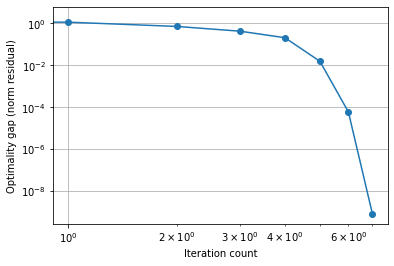

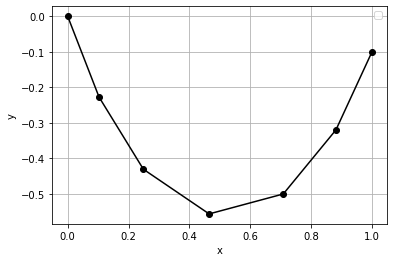

In [8]:
# With backtracking
x_sol, lmbda_sol, opt_gap = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True)
check_stationarity(x_sol, lmbda_sol, opt_gap)
plot_convergence(opt_gap)
# plt.savefig('cvg_noBT.svg', format = 'svg', dpi=300)
plot_chain(x_sol, a, b)
# plt.savefig('chain_noBT.svg', format = 'svg', dpi=300)

Eigenvalues :  2.47940475702964 27.1057990496733
A local optimizer found


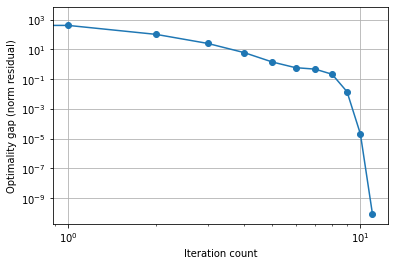

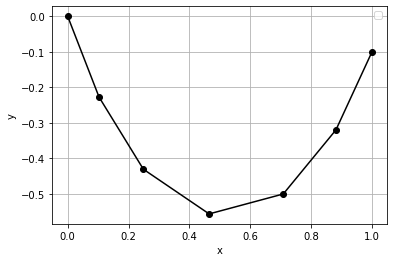

In [9]:
# Without backtracking
x_sol, lmbda_sol, opt_gap = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = False)
check_stationarity(x_sol, lmbda_sol, opt_gap)
plot_convergence(opt_gap)
# plt.savefig('cvg_BT.svg', format = 'svg', dpi=300)
plot_chain(x_sol, a, b)
# plt.savefig('chain_BT.svg', format = 'svg', dpi=300)

<h3> Convex relaxation </h3>

In [10]:
def solve_cvxpy(x, a, b, L):
    N = int(len(x) / 2)
    
    # Define variables
    u = cp.Variable((N+2,2))
    X = cp.Variable((N+2,N+2), symmetric = True)

    # Define constraints
    constraints = []
    for i in range(N+1):
        constraints += [X[i][i] - 2*X[i][i+1] + X[i+1][i+1] - L**2 == 0]
    constraints += [X[0][0] == 0]
    constraints += [X[N+1][N+1] == a**2 + b**2]
    constraints += [u[0][0] == 0]
    constraints += [u[0][1] == 0]
    constraints += [u[N+1][0] == a]
    constraints += [u[N+1][1] == b]

    I = np.eye(2)
    M = cp.bmat([[I, u.T],[u,X]])
    constraints += [M >> 0]

    # Define objective function
    obj = cp.Minimize(sum(u[:,1]))

    # Solve SDP problem
    prob = cp.Problem(obj, constraints)
    prob.solve()
    
    return [u.value, X.value]

Note that if the first two eigenvaues are much bigger than the rest, so the rank is close to 2
Eigenvalues: [ 3.13712104e+00  3.40860541e-01  4.88976357e-06  3.40694267e-06
 -4.08705387e-07 -4.18417137e-06 -7.34887486e-06]


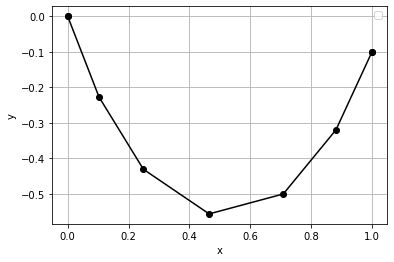

In [11]:
# cvxoy
N = 5
L = 0.25
a,b = 1.,-.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]

u, x = solve_cvxpy(x,a,b, L)
x_sol = np.concatenate((u.T[0],u.T[1]))

print("Note that if the first two eigenvaues are much bigger than the rest, so the rank is close to 2")
print("Eigenvalues:", np.linalg.eig(x)[0])

plot_chain(x_sol, a, b)
# plt.savefig('chain_cvxpy.svg', format = 'svg', dpi=300)

<strong> Initializing the Newton's method with the solutions from the convex relaxation </strong>

Eigenvalues :  2.4794047085467703 27.105798643122597
A local optimizer found


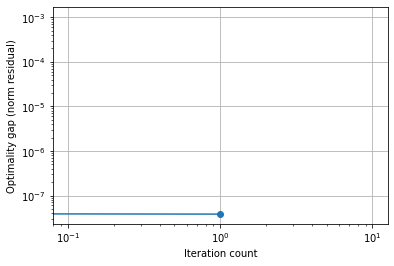

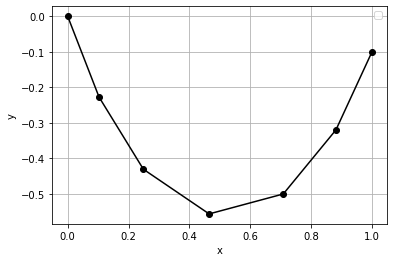

In [12]:
# Initializing the Newton's method with the solutions from the convex relaxation
x = np.zeros(2*N)
x[0:N] = u.T[0][1:N+1]
x[N:2*N] = u.T[1][1:N+1] 
lmbda = 0.1*np.random.random(N+1)

x_sol, lmbda_sol, opt_gap = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = False)
check_stationarity(x_sol, lmbda_sol, opt_gap)
plot_convergence(opt_gap)
# plt.savefig('cvg_initconvex.svg', format = 'svg', dpi=300)
plot_chain(x_sol, a, b)
# plt.savefig('chain_initconvex.svg', format = 'svg', dpi=300)

<h3> Comparing </h3>

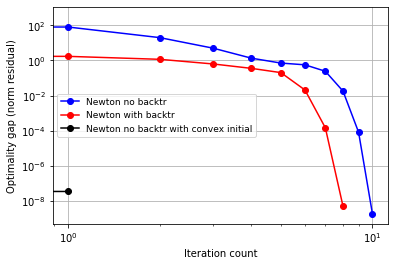

In [13]:
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)

# Without backtracking
x_sol, lmbda_sol, opt_gap1 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = False)
# With backtracking
x_sol, lmbda_sol, opt_gap2 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True)
# Without backtracking with convex initial
x[0:N] = u.T[0][1:N+1]
x[N:2*N] = u.T[1][1:N+1]
x_sol, lmbda_sol, opt_gap3 = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = False)

plt.loglog(opt_gap1, 'o-', label='Newton no backtr', color='blue')
plt.loglog(opt_gap2, 'o-', label='Newton with backtr', color='red')
plt.loglog(opt_gap3, 'o-', label='Newton no backtr with convex initial', color='black')
plt.grid()
plt.xlabel('Iteration count')
plt.ylabel('Optimality gap (norm residual)')
plt.legend(prop={'size':9})
plt.show()
# plt.savefig('cvg_total.svg',format = 'svg',dpi=300)